# 💼 Internship Assignment Round 2 – Wallet Risk Scoring From Scratch

**Applicant**:  **Sarthak Maddi**  
**Role**: **AI Engineer**  
**Date**: **[26/07/2025]**


## 📌 Objective  
Risk score wallets (0–1000) using Compound V2/V3 txn data based on behavior like txns, gas, failures, protocol use.


## Step 1: Load Wallet List and Import Libraries

In this step, I imported all the necessary Python libraries such as pandas, requests, matplotlib, seaborn, and scikit-learn.  
Then, I loaded a list of Ethereum wallet addresses from a shared Google Sheet and displayed the first few entries to verify the data.


In [8]:
# importing all the necessary libraries
import pandas as pd
import requests
import os
import time
import json
from datetime import datetime
from dateutil.parser import parse 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

In [2]:
url_data = "https://docs.google.com/spreadsheets/d/1ZzaeMgNYnxvriYYpe8PE7uMEblTI0GV5GIVUnsP-sBs/export?format=csv"
wallet_df = pd.read_csv(url_data)
wallets = wallet_df['wallet_id'].tolist()
print(wallet_df.head())

                                    wallet_id
0  0x0039f22efb07a647557c7c5d17854cfd6d489ef3
1  0x06b51c6882b27cb05e712185531c1f74996dd988
2  0x0795732aacc448030ef374374eaae57d2965c16c
3  0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9
4  0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae


In [3]:
print(wallets[:5])

['0x0039f22efb07a647557c7c5d17854cfd6d489ef3', '0x06b51c6882b27cb05e712185531c1f74996dd988', '0x0795732aacc448030ef374374eaae57d2965c16c', '0x0aaa79f1a86bc8136cd0d1ca0d51964f4e3766f9', '0x0fe383e5abc200055a7f391f94a5f5d1f844b9ae']


In [4]:
os.makedirs("wallet_data", exist_ok=True)

In [5]:
API_KEY = "cqt_rQ8t6yW8YD98q4cMRqCDTmDXHwFK" # this is my api key for using covalent api
CHAIN_ID = 1 # chain id for etherium to fetch data from

## Step 2: Fetching Wallet Transactions from Covalent API

In this step, I used the Covalent API to fetch Ethereum transaction data for each wallet.  
I created a `wallet_data` folder and looped through the wallet list, making an API call for each wallet.  
If the data already existed locally, I skipped it to save time. All transaction data was saved as `.json` files.


In [6]:
# here we are Looping through wallets and fetch their transactions
for idx, wallet in enumerate(wallets):
    filename = f"wallet_data/{wallet}.json"

    # If already fetched, skip this wallet
    if os.path.exists(filename):
        print(f"[{idx+1}/{len(wallets)}] Skipped ✅ (already saved): {wallet}")
        continue

    url = f"https://api.covalenthq.com/v1/{CHAIN_ID}/address/{wallet}/transactions_v2/?key={API_KEY}"

    success = False
    for attempt in range(3):
        try:
            response = requests.get(url, timeout=15)
            if response.status_code == 200:
                with open(filename, "w") as f:
                    json.dump(response.json(), f)
                success = True
                break
            else:
                print(f"Attempt {attempt+1} ❌ - Status code: {response.status_code}")
        except Exception as e:
            print(f"Attempt {attempt+1} ❌ - Error: {e}")
        time.sleep(2)

    if not success:
        print(f"⚠️ Failed after 3 attempts. Skipping wallet: {wallet}")

    time.sleep(1.5)

    if idx % 10 == 0 or idx == len(wallets) - 1:
        print(f"Progress: {idx+1}/{len(wallets)} wallets processed...")

print("Finished Fetching All Transactions from each wallet!!")


Progress: 1/103 wallets processed...
Progress: 11/103 wallets processed...
Progress: 21/103 wallets processed...
Progress: 31/103 wallets processed...
Progress: 41/103 wallets processed...
Progress: 51/103 wallets processed...
Progress: 61/103 wallets processed...
Progress: 71/103 wallets processed...
Progress: 81/103 wallets processed...
Progress: 91/103 wallets processed...
Progress: 101/103 wallets processed...
Progress: 103/103 wallets processed...
Finished Fetching All Transactions from each wallet!!


## Step 3: Extracting Features from Wallet Transaction Data

After fetching all transactions, I extracted useful features from each wallet's history.  
This included the number of transactions, failed transactions, total gas spent, average gas price, number of unique contracts interacted with, and how many times the wallet interacted with Compound protocol contracts.

I also captured the first and last transaction timestamps and saved everything into a CSV file called `wallet_features.csv`.


In [7]:
# This is the List of known Compound protocol contract addresses (mainnet) to me
compound_addresses = {
    "cUSDC": "0x39aa39c021dfbae8fac545936693ac917d5e7563",
    "cDAI": "0x5d3a536e4d6dbd6114cc1ead35777bab948e3643",
    "Comptroller": "0x3d9819210a31b4961b30ef54be2aed79b9c9cd3b",
    "cETH": "0x4ddc2d193948926d02f9b1fe9e1daa0718270ed5",
    # You can add more Compound addresses here if needed
}

# Converting addreses to lowercase for uniformity
compound_contracts = set(addr.lower() for addr in compound_addresses.values())

wallet_features = []

for idx, wallet in enumerate(wallets):
    filepath = f"wallet_data/{wallet}.json"

    if not os.path.exists(filepath):
        print(f"[{idx+1}] ❌ Missing file for: {wallet}")
        continue

    with open(filepath, "r") as f:
        data = json.load(f)

    if "data" not in data or "items" not in data["data"]:
        print(f"[{idx+1}] ❌ Invalid data format for: {wallet}")
        continue

    txns = data["data"]["items"]
    if not txns:
        print(f"[{idx+1}] ⚠️ No transactions for: {wallet}")
        continue

    num_txns = len(txns)
    num_failed_txns = sum(1 for tx in txns if not tx.get("successful"))
    total_gas_spent = sum(int(tx.get("gas_spent", 0)) for tx in txns)
    total_gas_price = sum(int(tx.get("gas_price", 0)) for tx in txns)
    avg_gas_price = total_gas_price / num_txns if num_txns > 0 else 0

    unique_contracts = len(set(tx.get("to_address") for tx in txns if tx.get("to_address")))

    # here we are Detecting Compound interactions by matching 'to_address'
    compound_count = sum(
    1 for tx in txns 
    if tx.get("to_address") and tx["to_address"].lower() in compound_contracts
    )


    timestamps = []
    for tx in txns:
        date_str = tx.get("block_signed_at")
        if date_str:
            try:
                timestamps.append(parse(date_str))
            except Exception as e:
                print(f"Error parsing date for wallet {wallet}: {e}")

    first_txn_date = min(timestamps) if timestamps else None
    last_txn_date = max(timestamps) if timestamps else None

    wallet_features.append({
        "wallet": wallet,
        "num_txns": num_txns,
        "num_failed_txns": num_failed_txns,
        "unique_contracts": unique_contracts,
        "total_gas_spent": total_gas_spent,
        "avg_gas_price": avg_gas_price,
        "num_compound_interactions": compound_count,
        "first_txn_date": first_txn_date.strftime("%d-%b-%Y %H:%M") if first_txn_date else None,
        "last_txn_date": last_txn_date.strftime("%d-%b-%Y %H:%M") if last_txn_date else None,
    })

df = pd.DataFrame(wallet_features)
df.to_csv("wallet_features.csv", index=False)
print("✅ Features extracted and saved to wallet_features.csv")


✅ Features extracted and saved to wallet_features.csv


## Step 4: Calculating Risk Scoring Using Feature Weights

I loaded the extracted wallet features from `wallet_features.csv` and calculated `wallet_age_days` using the difference between the first and last transaction dates.

Next, I visualized all major features to understand their distributions.

To estimate wallet risk, I created a simple proxy score (failed - Compound interactions) and trained a `RandomForestRegressor` to get feature importances. These importances were used as weights to compute a final `risk_score`.

The scores were normalized between 0–1000 and saved to `wallet_risk_scores.csv`.


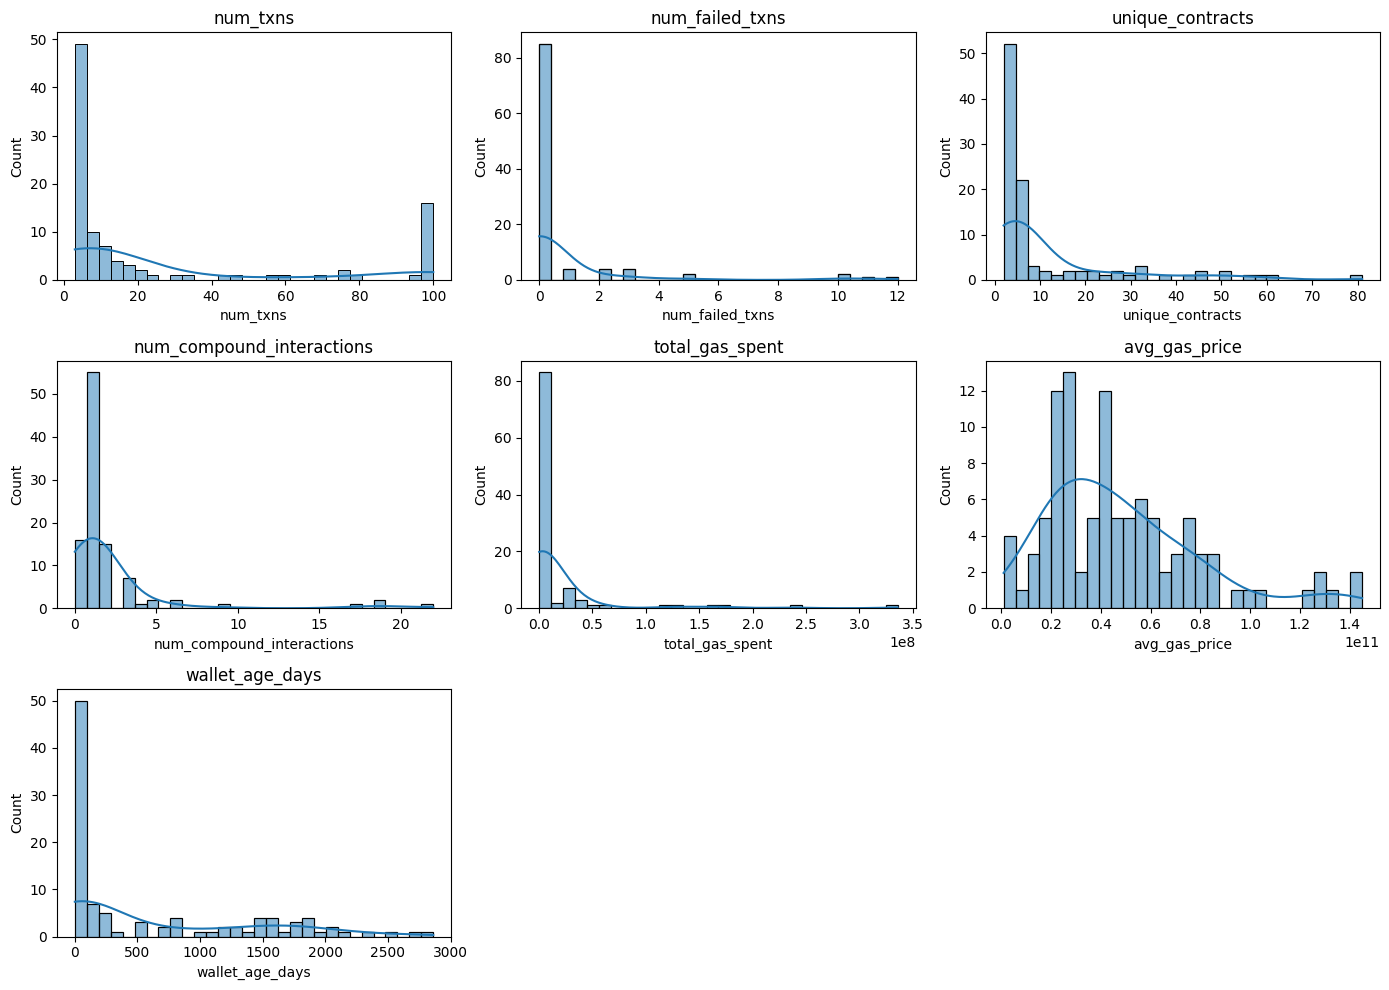


Feature Importances (used as weights):
num_txns: 0.0062
num_failed_txns: 0.2507
unique_contracts: 0.0072
num_compound_interactions: 0.6716
total_gas_spent: 0.0287
avg_gas_price: 0.0090
wallet_age_days: 0.0268

✅ Final wallet_risk_scores.csv saved with wallet_address and risk_score only.


In [15]:
df = pd.read_csv("wallet_features.csv")

df['first_txn_date'] = pd.to_datetime(df['first_txn_date'], errors='coerce')
df['last_txn_date'] = pd.to_datetime(df['last_txn_date'], errors='coerce')

# Calculating wallet age in days for each wallet
df['wallet_age_days'] = (df['last_txn_date'] - df['first_txn_date']).dt.days.fillna(0)
df = df.fillna(0)

features = [
    'num_txns',
    'num_failed_txns',
    'unique_contracts',
    'num_compound_interactions',
    'total_gas_spent',
    'avg_gas_price',
    'wallet_age_days'
]

plt.figure(figsize=(14, 10))
for i, col in enumerate(features):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"{col}")
    plt.tight_layout()
plt.show()

# it is a Simple risk proxy based on failed vs successful interactions
df['proxy_score'] = df['num_failed_txns'] - df['num_compound_interactions']

scaler = MinMaxScaler()
scaled = scaler.fit_transform(df[features])
scaled_df = pd.DataFrame(scaled, columns=features)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(scaled_df, df['proxy_score'])

importances = model.feature_importances_
weights = importances / importances.sum()
weight_dict = dict(zip(features, weights))

print("\nFeature Importances (used as weights):")
for k, v in weight_dict.items():
    print(f"{k}: {v:.4f}")

# Final weighted risk score which we need for assigning to wallet
df['risk_score'] = sum(scaled_df[col] * weight_dict[col] for col in features)

df['risk_score'] = ((df['risk_score'] - df['risk_score'].min()) /
                    (df['risk_score'].max() - df['risk_score'].min()) * 1000).astype(int)

df[['wallet', 'risk_score']].to_csv("wallet_risk_scores.csv", index=False)
print("\n✅ Final wallet_risk_scores.csv saved with wallet_address and risk_score only.")


## ✅ Summary

In this project, I analyzed transaction data of wallets interacting with the Compound protocol. I extracted key features, visualized them, and built a risk scoring system using a Random Forest model. Each wallet was assigned a risk score (0–1000) based on activity patterns, failed transactions, gas usage, and protocol interactions.
